In [1]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
from pathlib import Path

2023-09-27 10:21:35.178526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 10:21:37.061269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2023-09-27 10:21:37.061412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
FILE_PATH = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, cache_dir="datasets/quickdraw", extract=True)

1065301781/1065301781 [==============================] - 53s 0us/step


In [3]:
print(FILE_PATH)

/tmp/.keras/datasets/quickdraw_tutorial_dataset_v1.tar.gz


In [4]:
quickdraw_dir = Path(FILE_PATH).parent

In [5]:
training_files = sorted([str(file) for file in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(file) for file in quickdraw_dir.glob("eval.tfrecord-*")])

In [6]:
for file in quickdraw_dir.glob("*"):
    print(file)

/tmp/.keras/datasets/eval.tfrecord-00003-of-00010
/tmp/.keras/datasets/training.tfrecord-00001-of-00010
/tmp/.keras/datasets/training.tfrecord-00005-of-00010
/tmp/.keras/datasets/eval.tfrecord-00007-of-00010
/tmp/.keras/datasets/training.tfrecord-00009-of-00010
/tmp/.keras/datasets/eval.tfrecord-00004-of-00010
/tmp/.keras/datasets/training.tfrecord-00008-of-00010
/tmp/.keras/datasets/eval.tfrecord-00006-of-00010
/tmp/.keras/datasets/training.tfrecord.classes
/tmp/.keras/datasets/eval.tfrecord-00005-of-00010
/tmp/.keras/datasets/eval.tfrecord-00001-of-00010
/tmp/.keras/datasets/training.tfrecord-00006-of-00010
/tmp/.keras/datasets/training.tfrecord-00000-of-00010
/tmp/.keras/datasets/training.tfrecord-00002-of-00010
/tmp/.keras/datasets/eval.tfrecord.classes
/tmp/.keras/datasets/training.tfrecord-00007-of-00010
/tmp/.keras/datasets/training.tfrecord-00004-of-00010
/tmp/.keras/datasets/eval.tfrecord-00008-of-00010
/tmp/.keras/datasets/eval.tfrecord-00000-of-00010
/tmp/.keras/datasets/eva

In [7]:
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

In [8]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [9]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2],dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [10]:
def quickdraw_dataset(file_paths,batch_size=32, n_reads=5, n_calls=5, shuffle_buffer_size=None, cache=False):
    dataset = tf.data.TFRecordDataset(filenames=file_paths,num_parallel_reads=n_reads)

    if cache:
        dataset = dataset.cache()

    if shuffle_buffer_size:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_calls)
    return dataset

In [11]:
train_set = quickdraw_dataset(training_files, shuffle_buffer_size=10000)
test_set = quickdraw_dataset(eval_files[:5])
val_set = quickdraw_dataset(eval_files[5:])

2023-09-27 10:22:51.867256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 10:22:52.073794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 10:22:52.073852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 10:22:52.076065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [12]:
import matplotlib.pyplot as plt

In [94]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0.,0.,0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:,-1] == 1.)[:,0]
    cordinates = np.cumsum(sketch[:,:2], axis=0)
    strokes = np.split(cordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label else "Guess"
    plt.title(title)
    plt.plot(cordinates[:,0], -cordinates[:,1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
def draw_sketches(sketches, shapes, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, shape, label in zip(range(n_sketches), sketches, shapes, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch, label)

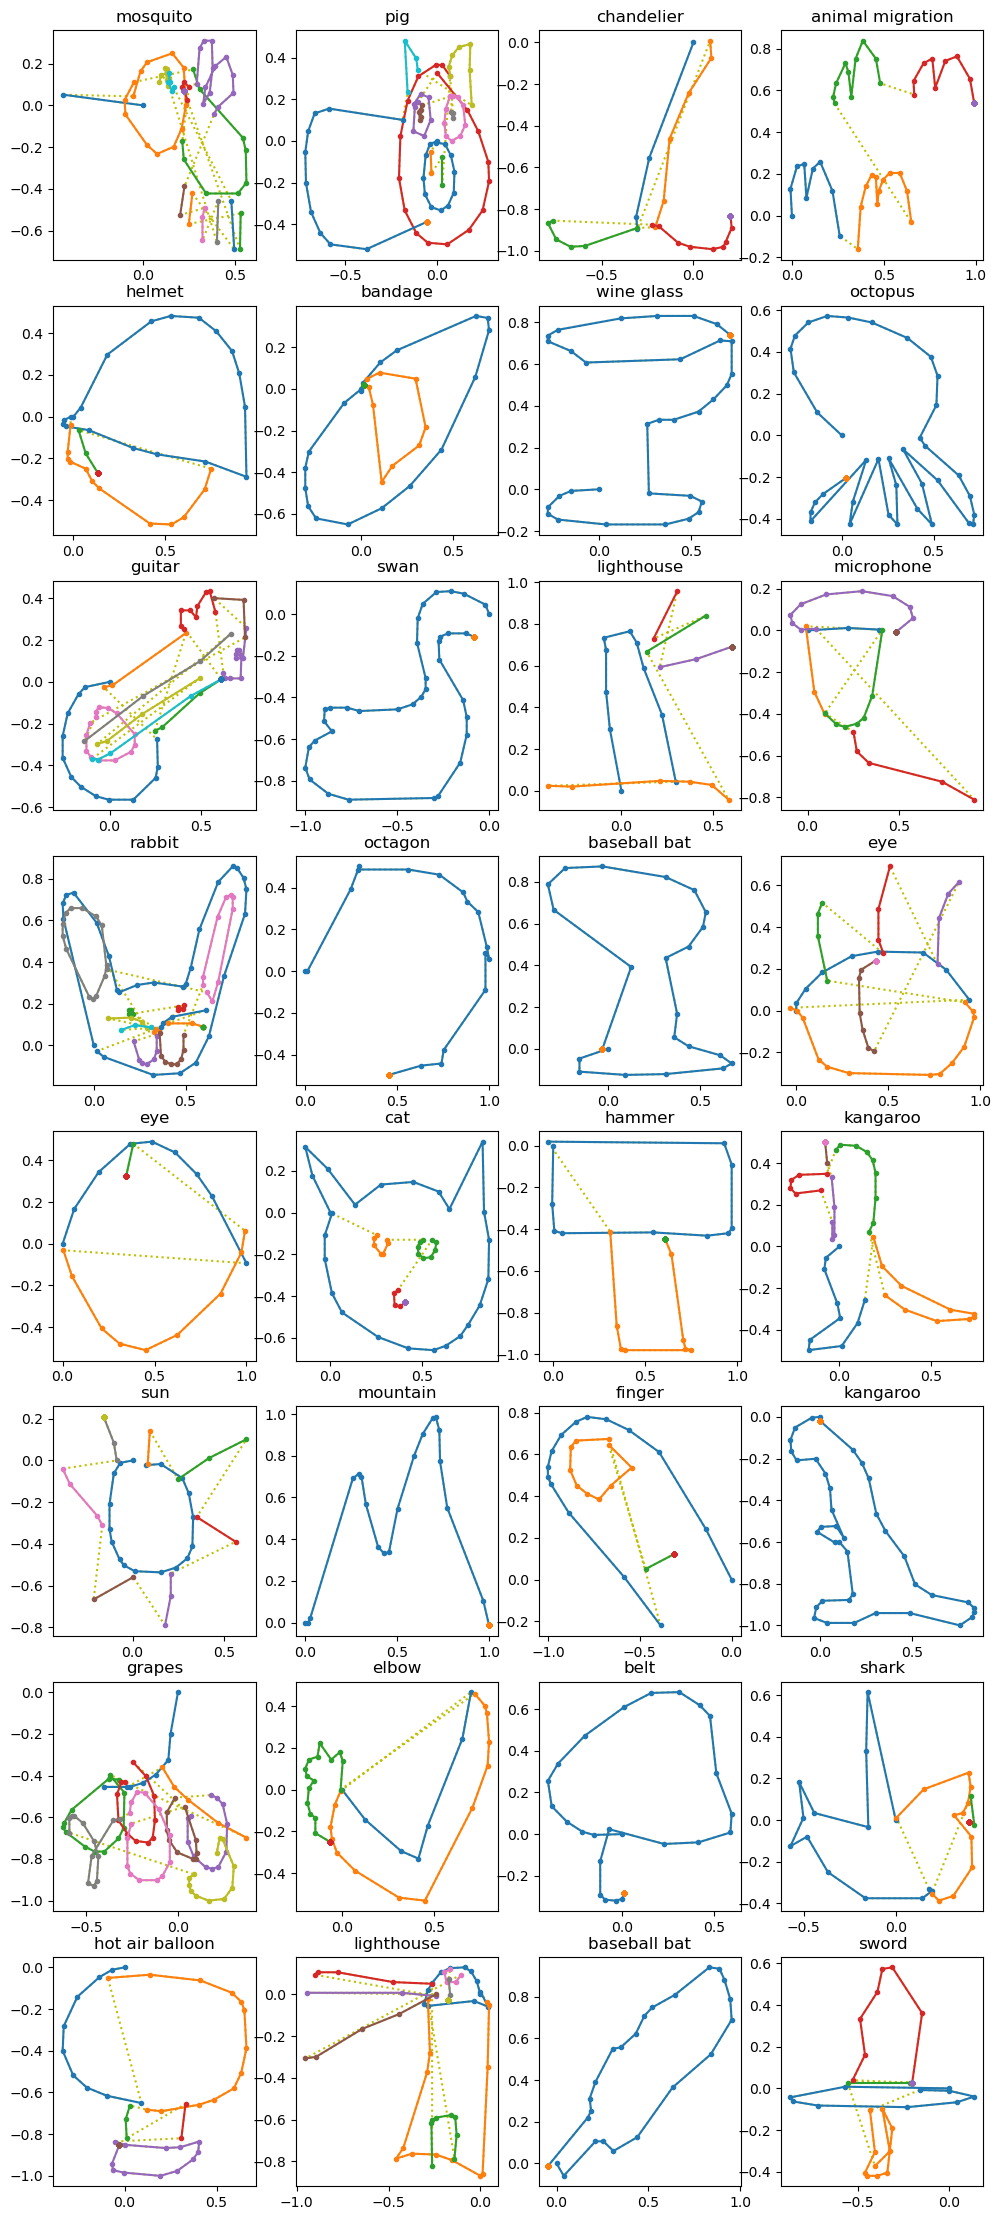

In [95]:
for sketches, shapes, labels in train_set.take(1):
    draw_sketches(sketches, shapes, labels)
